In [35]:
import numpy as np 
import pandas as pd 
import cv2
import os # used
from xml.etree import ElementTree # import to read/locate xml elemnts 
from matplotlib import pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from tensorflow.keras import datasets, layers, models, metrics, recall_score,
keras = tf.keras
from sklearn.metrics import recall_score

SyntaxError: trailing comma not allowed without surrounding parentheses (<ipython-input-35-972960be1525>, line 9)

In [9]:
# reducing size for the first model, original size is 500,442
size = (75, 50)

In [10]:
# create a function to load in data and label the classes person or person like, also to use on multi diff model with params.

def load_data(size=size):
    
    # datasets variable list of the 3 folders for train,test and validation
    datasets = ['Train/Train', 'Test/Test', 'Val/Val'] 
    
    #list to append the function
    output = []
   
    
    for dataset in datasets:
        
        images = [] # create list
        labels = [] # create list 
        
        # adding the dataset loop to the file path of Annotations(xml files)
        directoryANNOTATE = "Data/Pdata/" + dataset + "/Annotations/" 
        
        # adding the dataset loop to file path of images 
        directoryIMGAGES = "Data/Pdata/" + dataset + "/JPEGImages/" 
        
        # listdir() returns a list containing the names of the entries in the directory given by path, now we can loop it
        file = os.listdir(directoryANNOTATE) 
        jpg = os.listdir(directoryIMGAGES) 
        
        # organizing the annotations files to match the image order so the classes are labeled corrrctly to each image
        file.sort() 
        
        # organizing the images to match the order of the xml so the images are labeled correctly(person,like person)
        jpg.sort() 
        
        
        i = 0
        
        # loop through the xml files(file_) 
        #we need to match and idenify the class of each image by matching it with the annotation xml file
        for xml in file:
            
            # combining the annotations with the xml 
            xmlf = os.path.join(directoryANNOTATE,xml)
            
            # ElementTree represents the whole XML folder as a tree, and Element represents a single node in this tree. 
            dom = ElementTree.parse(xmlf)
            
            # iteriate through the xml annotations files and locate object element
            objct = dom.findall('object')  
            
            # from the object element now locate name element in the xml annotation file and only take the first object
            label_name = objct[0].find('name').text 
            
            # this will append all text either 'person / person like' found in the xml file
            # inside the name element, and saved off to the labeled_class 
            labels.append(labeled_class[label_name]) 
          
            # directory for images and the list of images to loop through
            img_path = directoryIMGAGES + jpg[i] 
            
            # taking rbg color value and assigning to tensor(3 dim matrix) (image data generator)
            curr_img = cv2.imread(img_path)
            
            
            # resize the org image to my custom perference 
            curr_img = cv2.resize(curr_img, size)
            
            
            #append the list of images that have been resized 
            images.append(curr_img) 
           
            
            # +1 to after the loop is completed it will move on to the next image to classify 
            i +=1
            
        # creating a numpy array of tensors, instead of list of tensors
        images = np.array(images, dtype='float32')
        
        
        # normalizing all images so the pixel values are between 0-1(image data generator)
        images = images / 255
        
        
        
        
        # tranforming the list of tensor to a numpy array.
        labels = np.array(labels, dtype='int32')
        
        
        # creating the list and joining together the labels and images
        output.append((images, labels)) 
       
    return output

In [11]:
classes = ['person','person-like'] 
# text to locate inside the xml person or person like

labeled_class = {class_name:i for i, class_name in enumerate(classes)} 
# setting up the dict keys person/personlike, iteriate and save the class labels 'person,person like'

n_classes = 2 
# 2 classes person or person like



#resizing the image to speed up model, actually image pixel size is (500,442)
size = (75,50)


In [12]:
# visual function to review the training acc score vs validation score, also the loss to see if we can minimize error

def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "train_acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "train_loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()


In [20]:
# loading in the data with the function
(train_images, train_labels),(test_images, test_labels),(val_images, val_labels) = load_data()

In [21]:
# confirm train size
train_images.shape

(944, 50, 75, 3)

In [22]:
# confirm label size matches image size (train_label = annotation xml files with class indication person or person_like)
train_labels.shape

(944,)

In [23]:
# reviewing image size (pixels) and how many images are in the validation folder 
val_images.shape

(160, 50, 75, 3)

In [24]:
# reviewing image size (pixels) and how many images are in the test folder 
test_images.shape

(235, 50, 75, 3)

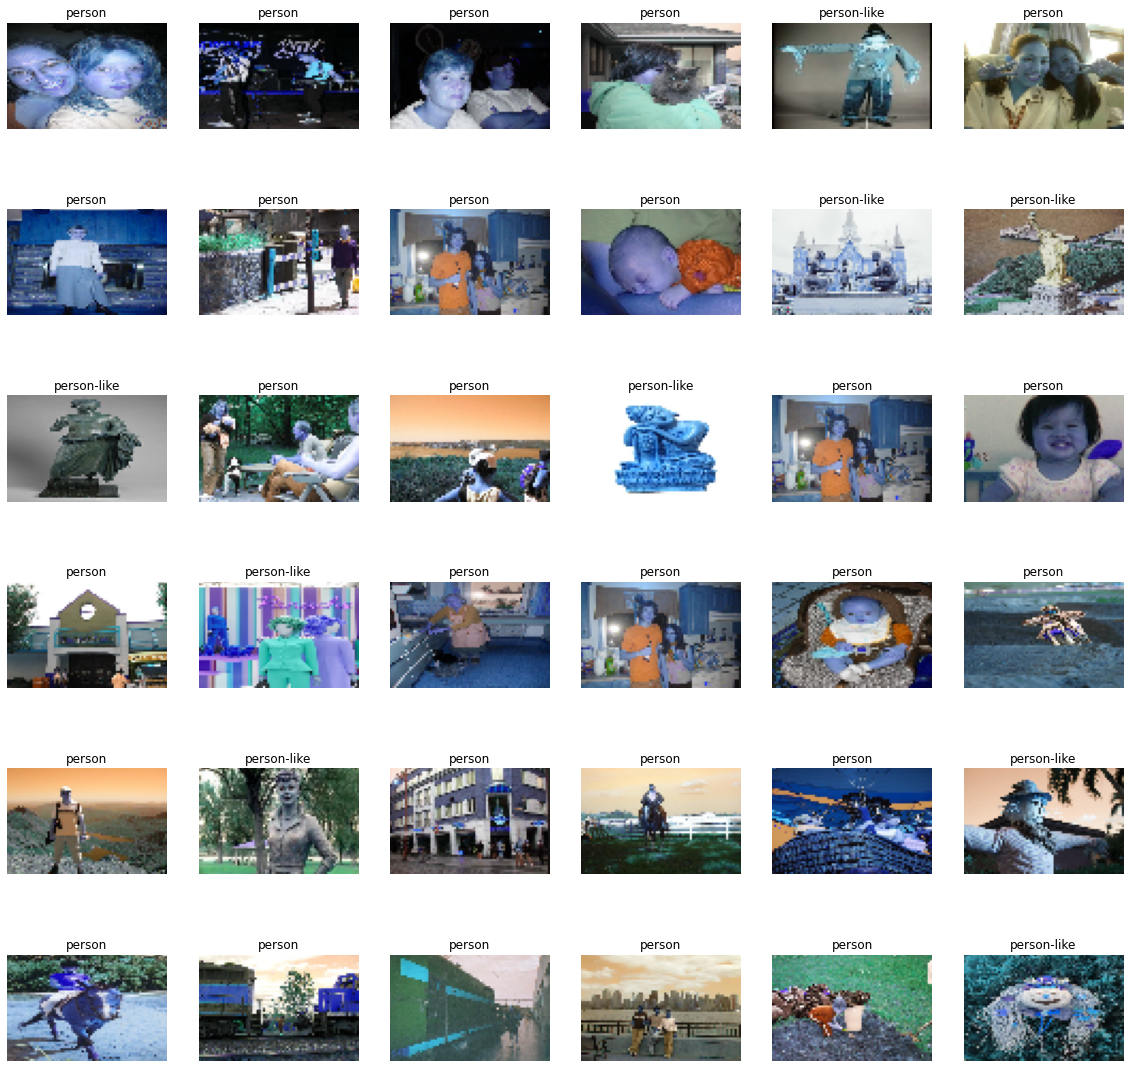

In [25]:
# looking at random images from training data
plt.figure(figsize=(20,20))
for n , i in enumerate(list(np.random.randint(0,len(train_images),10))) : 
    plt.subplot(6,6,n+1)
    plt.imshow(train_images[i])  
    plt.title(classes[train_labels[i]])
    plt.axis('off')

In [26]:
#Conv2d hyperparameter layout ( filter= learns how to detect features in the image to declare the class 
#                Kernel= the size of the filter/matrix as it transform the image 
#                strides= how many vectors the kernel moves across the matrix 
#                padding=analyzes the image to the edge/corner and beyond by 1 vector to optimize the analysis
#                activation = takes the output from pervious layer and passes it to the next layer(transforming the signal based on the function type)
#                input= pixel shape of image(200,200 matrix) and last digit in this case 3 = rgb(color image scale)
#                3 values combined in a single pixel will represent the final color the pixel displays
#                red value = 0, blue= 255, green= 255 this combination will result in yellow
#                255 is the brightest and highest value, will 1 being most faint, zero results as nonpresent  )

# Flatten is used to get my class prediction 
# 1 dense layer and sigmoid is used to get my signal class prediction 

# RMSProp with momentum generates its parameter updates using a momentum on the rescaled gradient,
# binary model only two classes
# specifically optimizing tp & fp want to detect all images correctly (accuracy)


In [27]:
# create CNN model first model 
                             
model = models.Sequential()
model.add(layers.Conv2D(filters=64, kernel_size=(5,5),strides=(1, 1),padding='same', activation='relu', input_shape=(50, 75, 3)))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Conv2D(filters=96, kernel_size=(5, 5),strides=(1, 1),padding='same', activation='relu'))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Conv2D(filters=108, kernel_size=(5, 5),strides=(1, 1),padding='same', activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',  
              metrics=['accuracy'])# specifically optimizing tp & fp want to detect all images correctly 


#saving off the model as an object for predicts etc...
history = model.fit(train_images, train_labels, epochs=30, batch_size=32,
                    validation_data=(val_images, val_labels))

Epoch 1/30
30/30 [==============================] - 8s 259ms/step - loss: 0.8390 - accuracy: 0.5561 - val_loss: 0.6947 - val_accuracy: 0.5312
Epoch 2/30
30/30 [==============================] - 8s 259ms/step - loss: 0.7006 - accuracy: 0.5646 - val_loss: 0.6839 - val_accuracy: 0.5312
Epoch 3/30
30/30 [==============================] - 8s 259ms/step - loss: 0.7992 - accuracy: 0.5985 - val_loss: 0.7076 - val_accuracy: 0.5312
Epoch 4/30
30/30 [==============================] - 8s 262ms/step - loss: 0.6740 - accuracy: 0.6208 - val_loss: 0.6476 - val_accuracy: 0.6125
Epoch 5/30
30/30 [==============================] - 7s 234ms/step - loss: 0.6281 - accuracy: 0.6409 - val_loss: 3.0100 - val_accuracy: 0.5312
Epoch 6/30
30/30 [==============================] - 7s 232ms/step - loss: 0.6721 - accuracy: 0.6441 - val_loss: 0.6176 - val_accuracy: 0.6313
Epoch 7/30
30/30 [==============================] - 7s 233ms/step - loss: 0.5795 - accuracy: 0.7044 - val_loss: 0.5096 - val_accuracy: 0.7625
Epoch 

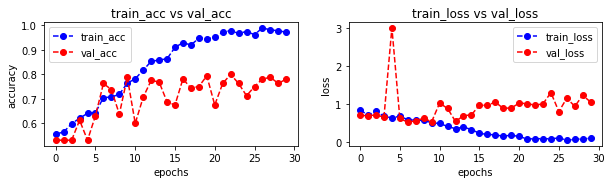

In [28]:
# visual to review the accuracy and loss per epoch on both validation and training 
plot_accuracy_loss(history)

In [29]:
# CNN model #2 reducing CNN layers 
                             
model = models.Sequential()
model.add(layers.Conv2D(filters=12, kernel_size=(5,5),strides=(1, 1),padding='same', activation='relu', input_shape=(50, 75, 3)))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Conv2D(filters=6, kernel_size=(5, 5),strides=(1, 1),padding='same', activation='relu'))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Conv2D(filters=4, kernel_size=(5, 5),strides=(1, 1),padding='same', activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',  
              metrics=['accuracy'])# specifically optimizing tp & fp want to detect all images correctly 


#saving off the model as an object for predicts etc...
history_2 = model.fit(train_images, train_labels, epochs=200, batch_size=32,
                    validation_data=(val_images, val_labels))

Epoch 1/200
30/30 [==============================] - 4s 140ms/step - loss: 0.6897 - accuracy: 0.5646 - val_loss: 0.6850 - val_accuracy: 0.5312
Epoch 2/200
30/30 [==============================] - 4s 124ms/step - loss: 0.6757 - accuracy: 0.5646 - val_loss: 0.6863 - val_accuracy: 0.5312
Epoch 3/200
30/30 [==============================] - 4s 126ms/step - loss: 0.6616 - accuracy: 0.5646 - val_loss: 0.7500 - val_accuracy: 0.5312
Epoch 4/200
30/30 [==============================] - 4s 127ms/step - loss: 0.6470 - accuracy: 0.5646 - val_loss: 0.6526 - val_accuracy: 0.5312
Epoch 5/200
30/30 [==============================] - 4s 126ms/step - loss: 0.6346 - accuracy: 0.5996 - val_loss: 0.6442 - val_accuracy: 0.6125
Epoch 6/200
30/30 [==============================] - 4s 126ms/step - loss: 0.6263 - accuracy: 0.6525 - val_loss: 0.6441 - val_accuracy: 0.6812
Epoch 7/200
30/30 [==============================] - 4s 123ms/step - loss: 0.6175 - accuracy: 0.6642 - val_loss: 0.6290 - val_accuracy: 0.6062

Epoch 58/200
30/30 [==============================] - 4s 128ms/step - loss: 0.2037 - accuracy: 0.9513 - val_loss: 0.6270 - val_accuracy: 0.7812
Epoch 59/200
30/30 [==============================] - 4s 128ms/step - loss: 0.1824 - accuracy: 0.9725 - val_loss: 0.7592 - val_accuracy: 0.7563
Epoch 60/200
30/30 [==============================] - 4s 127ms/step - loss: 0.1894 - accuracy: 0.9629 - val_loss: 0.6643 - val_accuracy: 0.7812
Epoch 61/200
30/30 [==============================] - 4s 128ms/step - loss: 0.1846 - accuracy: 0.9661 - val_loss: 0.7263 - val_accuracy: 0.7625
Epoch 62/200
30/30 [==============================] - 4s 129ms/step - loss: 0.1833 - accuracy: 0.9619 - val_loss: 0.7254 - val_accuracy: 0.7688
Epoch 63/200
30/30 [==============================] - 4s 128ms/step - loss: 0.1681 - accuracy: 0.9693 - val_loss: 0.7293 - val_accuracy: 0.7688
Epoch 64/200
30/30 [==============================] - 4s 124ms/step - loss: 0.1675 - accuracy: 0.9682 - val_loss: 0.6871 - val_accuracy:

Epoch 115/200
30/30 [==============================] - 4s 128ms/step - loss: 0.0791 - accuracy: 0.9778 - val_loss: 1.2480 - val_accuracy: 0.7500
Epoch 116/200
30/30 [==============================] - 4s 127ms/step - loss: 0.0615 - accuracy: 0.9894 - val_loss: 0.9248 - val_accuracy: 0.7375
Epoch 117/200
30/30 [==============================] - 4s 131ms/step - loss: 0.0755 - accuracy: 0.9841 - val_loss: 1.6024 - val_accuracy: 0.7563
Epoch 118/200
30/30 [==============================] - 4s 127ms/step - loss: 0.0608 - accuracy: 0.9905 - val_loss: 1.3960 - val_accuracy: 0.7500
Epoch 119/200
30/30 [==============================] - 4s 127ms/step - loss: 0.0622 - accuracy: 0.9883 - val_loss: 1.1797 - val_accuracy: 0.7563
Epoch 120/200
30/30 [==============================] - 4s 127ms/step - loss: 0.0844 - accuracy: 0.9809 - val_loss: 1.3040 - val_accuracy: 0.7375
Epoch 121/200
30/30 [==============================] - 4s 127ms/step - loss: 0.0550 - accuracy: 0.9915 - val_loss: 1.3966 - val_ac

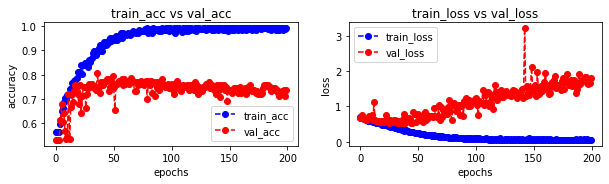

In [30]:
# visual to review the accuracy and loss per epoch on both validation and training
plot_accuracy_loss(history_2)

In [41]:
# loading in the data
(train_images_2, train_labels_2),(test_images_2, test_labels_2),(val_images_2, val_labels_2) = load_data(size = (200,200))

In [43]:
# CNN model #3 incrasing cnn layers and raising the pixel dimensions 
                             
model = models.Sequential()
model.add(layers.Conv2D(filters=64, kernel_size=(5,5),strides=(1, 1),padding='same', activation='relu', input_shape=(200, 200, 3)))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Conv2D(filters=96, kernel_size=(5, 5),strides=(1, 1),padding='same', activation='relu'))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Conv2D(filters=108, kernel_size=(5, 5),strides=(1, 1),padding='same', activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',  
              metrics=['accuracy'])# specifically optimizing tp & fp want to detect all images correctly 


#saving off the model as an object for predicts etc...
history_3 = model.fit(train_images_2, train_labels_2, epochs=30, batch_size=32,
                    validation_data=(val_images_2, val_labels_2))

Epoch 1/30
30/30 [==============================] - 127s 4s/step - loss: 1.5821 - accuracy: 0.5381 - val_loss: 0.6837 - val_accuracy: 0.5063
Epoch 2/30
30/30 [==============================] - 123s 4s/step - loss: 0.7072 - accuracy: 0.5530 - val_loss: 0.6665 - val_accuracy: 0.6687
Epoch 3/30
30/30 [==============================] - 126s 4s/step - loss: 0.7836 - accuracy: 0.5244 - val_loss: 0.6665 - val_accuracy: 0.5312
Epoch 4/30
30/30 [==============================] - 131s 4s/step - loss: 0.8557 - accuracy: 0.5286 - val_loss: 0.6857 - val_accuracy: 0.5500
Epoch 5/30
30/30 [==============================] - 130s 4s/step - loss: 0.7789 - accuracy: 0.5731 - val_loss: 0.6684 - val_accuracy: 0.7063
Epoch 6/30
30/30 [==============================] - 129s 4s/step - loss: 0.6858 - accuracy: 0.6112 - val_loss: 0.6472 - val_accuracy: 0.6875
Epoch 7/30
30/30 [==============================] - 131s 4s/step - loss: 0.7526 - accuracy: 0.6610 - val_loss: 1.9096 - val_accuracy: 0.5437
Epoch 8/30
30

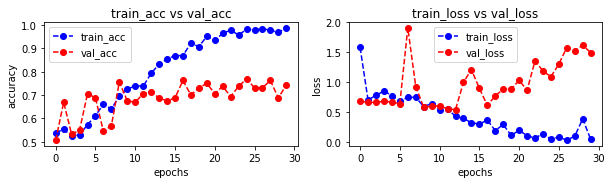

In [44]:
# visual to review the accuracy and loss per epoch on both validation and training
plot_accuracy_loss(history_3)

In [45]:
# loading in the data
(train_images_3, train_labels_3),(test_images_3, test_labels_3),(val_images_3, val_labels_3) = load_data(size = (100,80))

In [46]:
train_images_3.shape

(944, 80, 100, 3)

In [47]:
# CNN model #4 reducing pixel dim in the middle of my previous models
                             
model = models.Sequential()
model.add(layers.Conv2D(filters=64, kernel_size=(5,5),strides=(1, 1),padding='same', activation='relu', input_shape=(80,100, 3)))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Conv2D(filters=96, kernel_size=(5, 5),strides=(1, 1),padding='same', activation='relu'))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Conv2D(filters=108, kernel_size=(5, 5),strides=(1, 1),padding='same', activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',  
              metrics=['accuracy'])# specifically optimizing tp & fp want to detect all images correctly 


#saving off the model as an object for predicts etc...
history_4 = model.fit(train_images_3, train_labels_3, epochs=30, batch_size=32,
                    validation_data=(val_images_3, val_labels_3))

Epoch 1/30
30/30 [==============================] - 29s 955ms/step - loss: 0.9849 - accuracy: 0.5307 - val_loss: 0.6860 - val_accuracy: 0.5437
Epoch 2/30
30/30 [==============================] - 28s 938ms/step - loss: 0.6911 - accuracy: 0.5816 - val_loss: 0.6744 - val_accuracy: 0.6625
Epoch 3/30
30/30 [==============================] - 28s 936ms/step - loss: 0.6933 - accuracy: 0.5784 - val_loss: 0.6746 - val_accuracy: 0.6438
Epoch 4/30
30/30 [==============================] - 28s 936ms/step - loss: 0.6947 - accuracy: 0.5932 - val_loss: 0.6778 - val_accuracy: 0.6625
Epoch 5/30
30/30 [==============================] - 30s 995ms/step - loss: 0.7556 - accuracy: 0.6229 - val_loss: 0.6390 - val_accuracy: 0.6375
Epoch 6/30
30/30 [==============================] - 32s 1s/step - loss: 0.6676 - accuracy: 0.6165 - val_loss: 0.6142 - val_accuracy: 0.7312
Epoch 7/30
30/30 [==============================] - 28s 940ms/step - loss: 0.6121 - accuracy: 0.6843 - val_loss: 0.5422 - val_accuracy: 0.7563
Ep

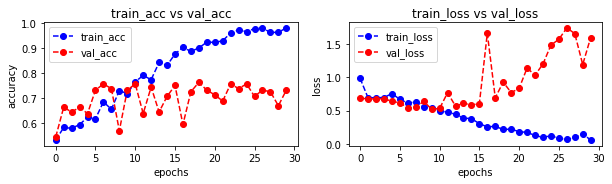

In [48]:
# visual to review the accuracy and loss per epoch on both validation and training
plot_accuracy_loss(history_4)

In [49]:
# CNN model #5 decreasing cnn layers and dense 
                             
model = models.Sequential()
model.add(layers.Conv2D(filters=36, kernel_size=(5,5),strides=(1, 1),padding='same', activation='relu', input_shape=(80,100, 3)))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Conv2D(filters=24, kernel_size=(5, 5),strides=(1, 1),padding='same', activation='relu'))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Conv2D(filters=12, kernel_size=(5, 5),strides=(1, 1),padding='same', activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',  
              metrics=['accuracy'])# specifically optimizing tp & fp want to detect all images correctly 


#saving off the model as an object for predicts etc...
history_5 = model.fit(train_images_3, train_labels_3, epochs=50, batch_size=32,
                    validation_data=(val_images_3, val_labels_3))

Epoch 1/50
30/30 [==============================] - 13s 429ms/step - loss: 0.6969 - accuracy: 0.5530 - val_loss: 0.6864 - val_accuracy: 0.6375
Epoch 2/50
30/30 [==============================] - 12s 413ms/step - loss: 0.6833 - accuracy: 0.5932 - val_loss: 0.9509 - val_accuracy: 0.5312
Epoch 3/50
30/30 [==============================] - 13s 419ms/step - loss: 0.6788 - accuracy: 0.6017 - val_loss: 0.6552 - val_accuracy: 0.6375
Epoch 4/50
30/30 [==============================] - 13s 419ms/step - loss: 0.6631 - accuracy: 0.6292 - val_loss: 0.8968 - val_accuracy: 0.5312
Epoch 5/50
30/30 [==============================] - 13s 424ms/step - loss: 0.6407 - accuracy: 0.6653 - val_loss: 0.5888 - val_accuracy: 0.6500
Epoch 6/50
30/30 [==============================] - 14s 467ms/step - loss: 0.6057 - accuracy: 0.6780 - val_loss: 0.5801 - val_accuracy: 0.6500
Epoch 7/50
30/30 [==============================] - 15s 492ms/step - loss: 0.5967 - accuracy: 0.6864 - val_loss: 0.5936 - val_accuracy: 0.6438

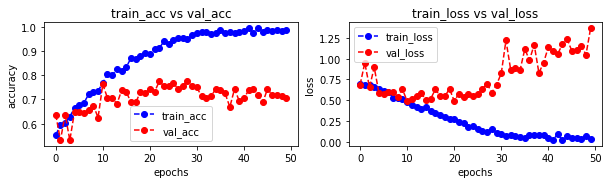

In [50]:
# visual to review the accuracy and loss per epoch on both validation and training
plot_accuracy_loss(history_5)

In [13]:
# loading in the data
(train_images_4, train_labels_4),(test_images_4, test_labels_4),(val_images_4, val_labels_4) = load_data(size = (50,50))

In [52]:
# CNN model # 6 decreasing the pixel shape to the smallest yet 
                             
model = models.Sequential()
model.add(layers.Conv2D(filters=64, kernel_size=(5,5),strides=(1, 1),padding='same', activation='relu', input_shape=(50, 50, 3)))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Conv2D(filters=96, kernel_size=(5, 5),strides=(1, 1),padding='same', activation='relu'))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Conv2D(filters=108, kernel_size=(5, 5),strides=(1, 1),padding='same', activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',  
              metrics=['accuracy'])# specifically optimizing tp & fp want to detect all images correctly 


#saving off the model as an object for predicts etc...
history_6 = model.fit(train_images_4, train_labels_4, epochs=30, batch_size=32,
                    validation_data=(val_images_4, val_labels_4))

Epoch 1/30
30/30 [==============================] - 10s 331ms/step - loss: 0.7040 - accuracy: 0.5530 - val_loss: 0.6774 - val_accuracy: 0.5813
Epoch 2/30
30/30 [==============================] - 9s 305ms/step - loss: 0.6826 - accuracy: 0.5996 - val_loss: 0.6310 - val_accuracy: 0.6500
Epoch 3/30
30/30 [==============================] - 9s 306ms/step - loss: 0.6781 - accuracy: 0.6123 - val_loss: 0.6517 - val_accuracy: 0.5375
Epoch 4/30
30/30 [==============================] - 9s 295ms/step - loss: 0.6687 - accuracy: 0.6091 - val_loss: 0.6212 - val_accuracy: 0.7937
Epoch 5/30
30/30 [==============================] - 9s 310ms/step - loss: 0.6207 - accuracy: 0.6610 - val_loss: 0.5853 - val_accuracy: 0.6875
Epoch 6/30
30/30 [==============================] - 9s 315ms/step - loss: 0.5683 - accuracy: 0.7044 - val_loss: 0.5278 - val_accuracy: 0.7188
Epoch 7/30
30/30 [==============================] - 10s 332ms/step - loss: 0.4969 - accuracy: 0.7458 - val_loss: 0.5047 - val_accuracy: 0.7437
Epoc

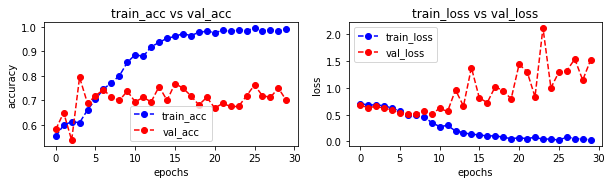

In [53]:
# visual to review the accuracy and loss per epoch on both validation and training
plot_accuracy_loss(history_6)

### The next model I will reduce overfitting by lowering the filter do make the model less complex. Model 7

In [54]:
# create CNN model# 7 (92,75) decreasing the cnn layers, adjusting kernal size 
                             
model = models.Sequential()
model.add(layers.Conv2D(filters=8, kernel_size=(3,3),strides=(1, 1),padding='same', activation='relu', input_shape=(50, 50, 3)))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Conv2D(filters=6, kernel_size=(3, 3),strides=(1, 1),padding='same', activation='relu'))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Conv2D(filters=4, kernel_size=(3, 3),strides=(1, 1),padding='same', activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',  
              metrics=['accuracy'])# specifically optimizing tp & fp want to detect all images correctly 


#saving off the model as an object for predicts etc...
history_7 = model.fit(train_images_4, train_labels_4, epochs=120, batch_size=32,
                    validation_data=(val_images_4, val_labels_4))

Epoch 1/120
30/30 [==============================] - 2s 60ms/step - loss: 0.6862 - accuracy: 0.5689 - val_loss: 0.6838 - val_accuracy: 0.5437
Epoch 2/120
30/30 [==============================] - 1s 47ms/step - loss: 0.6760 - accuracy: 0.5742 - val_loss: 0.6729 - val_accuracy: 0.6375
Epoch 3/120
30/30 [==============================] - 1s 47ms/step - loss: 0.6640 - accuracy: 0.6144 - val_loss: 0.6542 - val_accuracy: 0.6313
Epoch 4/120
30/30 [==============================] - 1s 46ms/step - loss: 0.6542 - accuracy: 0.6144 - val_loss: 0.6392 - val_accuracy: 0.6562
Epoch 5/120
30/30 [==============================] - 1s 46ms/step - loss: 0.6407 - accuracy: 0.6684 - val_loss: 0.6314 - val_accuracy: 0.6438
Epoch 6/120
30/30 [==============================] - 1s 44ms/step - loss: 0.6311 - accuracy: 0.6600 - val_loss: 0.6510 - val_accuracy: 0.6313
Epoch 7/120
30/30 [==============================] - 1s 46ms/step - loss: 0.6260 - accuracy: 0.6430 - val_loss: 0.6219 - val_accuracy: 0.6562
Epoch 

Epoch 115/120
30/30 [==============================] - 1s 48ms/step - loss: 0.2300 - accuracy: 0.9068 - val_loss: 0.7711 - val_accuracy: 0.7750
Epoch 116/120
30/30 [==============================] - 1s 46ms/step - loss: 0.2348 - accuracy: 0.8941 - val_loss: 0.6389 - val_accuracy: 0.7750
Epoch 117/120
30/30 [==============================] - 1s 45ms/step - loss: 0.2313 - accuracy: 0.9036 - val_loss: 0.6183 - val_accuracy: 0.7500
Epoch 118/120
30/30 [==============================] - 1s 46ms/step - loss: 0.2419 - accuracy: 0.8972 - val_loss: 0.6762 - val_accuracy: 0.7375
Epoch 119/120
30/30 [==============================] - 1s 46ms/step - loss: 0.2328 - accuracy: 0.9004 - val_loss: 0.8225 - val_accuracy: 0.7188
Epoch 120/120
30/30 [==============================] - 1s 46ms/step - loss: 0.2267 - accuracy: 0.9153 - val_loss: 0.7523 - val_accuracy: 0.7750


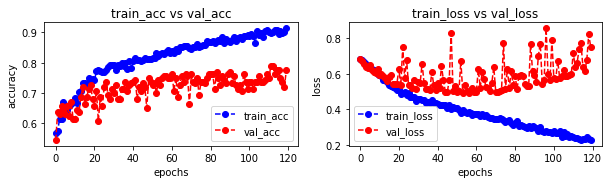

In [55]:
# visual to review the accuracy and loss per epoch on both validation and training
plot_accuracy_loss(history_7)

### Switching to swish activation to get the training and validation scores both in the 90s

In [56]:
# create CNN model #8 review a swish activation to prevent overfitting                             
model = models.Sequential()
model.add(layers.Conv2D(filters=8, kernel_size=(3,3),strides=(1, 1),padding='same', activation='swish', input_shape=(50, 50, 3)))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Conv2D(filters=6, kernel_size=(3, 3),strides=(1, 1),padding='same', activation='swish'))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Conv2D(filters=4, kernel_size=(3, 3),strides=(1, 1),padding='same', activation='swish'))
model.add(layers.Flatten())
model.add(layers.Dense(8, activation='swish'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',  
              metrics=['accuracy'])# specifically optimizing tp & fp want to detect all images correctly 


#saving off the model as an object for predicts etc...
history_8 = model.fit(train_images_4, train_labels_4, epochs=200, batch_size=32,
                    validation_data=(val_images_4, val_labels_4))

Epoch 1/200
30/30 [==============================] - 2s 67ms/step - loss: 0.6896 - accuracy: 0.5583 - val_loss: 0.6857 - val_accuracy: 0.5375
Epoch 2/200
30/30 [==============================] - 2s 54ms/step - loss: 0.6806 - accuracy: 0.6049 - val_loss: 0.6708 - val_accuracy: 0.6062
Epoch 3/200
30/30 [==============================] - 2s 53ms/step - loss: 0.6621 - accuracy: 0.6271 - val_loss: 0.6368 - val_accuracy: 0.6500
Epoch 4/200
30/30 [==============================] - 2s 52ms/step - loss: 0.6367 - accuracy: 0.6600 - val_loss: 0.5897 - val_accuracy: 0.7250
Epoch 5/200
30/30 [==============================] - 2s 54ms/step - loss: 0.6288 - accuracy: 0.6377 - val_loss: 0.5800 - val_accuracy: 0.7000
Epoch 6/200
30/30 [==============================] - 2s 51ms/step - loss: 0.6234 - accuracy: 0.6398 - val_loss: 0.5866 - val_accuracy: 0.6625
Epoch 7/200
30/30 [==============================] - 2s 52ms/step - loss: 0.6108 - accuracy: 0.6472 - val_loss: 0.5576 - val_accuracy: 0.7125
Epoch 

Epoch 58/200
30/30 [==============================] - 2s 51ms/step - loss: 0.4252 - accuracy: 0.7977 - val_loss: 0.7594 - val_accuracy: 0.6750
Epoch 59/200
30/30 [==============================] - 2s 54ms/step - loss: 0.4366 - accuracy: 0.7998 - val_loss: 0.6692 - val_accuracy: 0.7000
Epoch 60/200
30/30 [==============================] - 2s 57ms/step - loss: 0.4229 - accuracy: 0.7881 - val_loss: 0.7059 - val_accuracy: 0.6812
Epoch 61/200
30/30 [==============================] - 2s 54ms/step - loss: 0.4361 - accuracy: 0.7850 - val_loss: 0.5580 - val_accuracy: 0.7437
Epoch 62/200
30/30 [==============================] - 2s 54ms/step - loss: 0.4258 - accuracy: 0.7987 - val_loss: 0.5630 - val_accuracy: 0.7250
Epoch 63/200
30/30 [==============================] - 2s 59ms/step - loss: 0.4296 - accuracy: 0.7797 - val_loss: 0.6490 - val_accuracy: 0.6812
Epoch 64/200
30/30 [==============================] - 2s 58ms/step - loss: 0.4239 - accuracy: 0.7987 - val_loss: 0.5860 - val_accuracy: 0.7188

Epoch 172/200
30/30 [==============================] - 2s 54ms/step - loss: 0.2118 - accuracy: 0.9142 - val_loss: 0.9160 - val_accuracy: 0.6938
Epoch 173/200
30/30 [==============================] - 2s 53ms/step - loss: 0.1975 - accuracy: 0.9280 - val_loss: 1.0439 - val_accuracy: 0.7250
Epoch 174/200
30/30 [==============================] - 2s 52ms/step - loss: 0.1955 - accuracy: 0.9216 - val_loss: 1.2198 - val_accuracy: 0.6875
Epoch 175/200
30/30 [==============================] - 2s 53ms/step - loss: 0.2128 - accuracy: 0.9100 - val_loss: 1.0017 - val_accuracy: 0.6938
Epoch 176/200
30/30 [==============================] - 2s 52ms/step - loss: 0.1913 - accuracy: 0.9301 - val_loss: 1.0788 - val_accuracy: 0.7063
Epoch 177/200
30/30 [==============================] - 1s 50ms/step - loss: 0.2076 - accuracy: 0.9142 - val_loss: 1.0280 - val_accuracy: 0.6938
Epoch 178/200
30/30 [==============================] - 2s 51ms/step - loss: 0.1862 - accuracy: 0.9322 - val_loss: 1.0173 - val_accuracy:

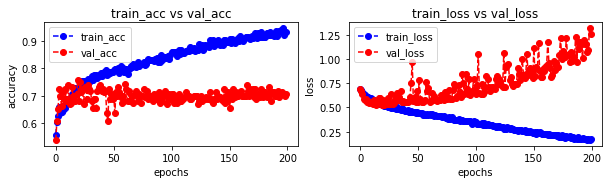

In [57]:
# visual to review the accuracy and loss per epoch on both validation and training
plot_accuracy_loss(history_8)

In [30]:
# create CNN model# 7 (92,75)
# this previous model had the smallest gap from training to validation , going to decrease layers and add more epochs
                             
model = models.Sequential()
model.add(layers.Conv2D(filters=12, kernel_size=(2, 2), activation='relu', input_shape=(50, 50, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(filters=16, kernel_size=(2, 2), activation='relu'))
model.add(layers.Dropout(rate=np.random.rand()))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(filters=20, kernel_size=(2, 2), activation='relu'))
model.add(layers.Dropout(rate=np.random.rand()))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(filters=8, kernel_size=(2, 2), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(20, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',  
              metrics=['accuracy'])# specifically optimizing tp & fp want to detect all images correctly 


#saving off the model as an object for predicts etc...
history_8 = model.fit(train_images_4, train_labels_4, epochs=200, batch_size=32,
                    validation_data=(val_images_4, val_labels_4))

Epoch 1/200
30/30 [==============================] - 1s 45ms/step - loss: 0.6936 - accuracy: 0.5233 - val_loss: 0.6921 - val_accuracy: 0.5312
Epoch 2/200
30/30 [==============================] - 1s 38ms/step - loss: 0.6864 - accuracy: 0.5646 - val_loss: 0.6905 - val_accuracy: 0.5312
Epoch 3/200
30/30 [==============================] - 1s 40ms/step - loss: 0.6761 - accuracy: 0.5773 - val_loss: 0.6606 - val_accuracy: 0.5375
Epoch 4/200
30/30 [==============================] - 1s 45ms/step - loss: 0.6472 - accuracy: 0.6155 - val_loss: 0.6569 - val_accuracy: 0.5625
Epoch 5/200
30/30 [==============================] - 1s 47ms/step - loss: 0.6011 - accuracy: 0.6769 - val_loss: 0.5786 - val_accuracy: 0.7312
Epoch 6/200
30/30 [==============================] - 1s 44ms/step - loss: 0.5558 - accuracy: 0.7193 - val_loss: 0.5471 - val_accuracy: 0.6812
Epoch 7/200
30/30 [==============================] - 1s 45ms/step - loss: 0.5208 - accuracy: 0.7585 - val_loss: 0.5267 - val_accuracy: 0.7563
Epoch 

30/30 [==============================] - 1s 41ms/step - loss: 0.2310 - accuracy: 0.8962 - val_loss: 0.4373 - val_accuracy: 0.8062
Epoch 59/200
30/30 [==============================] - 1s 35ms/step - loss: 0.2342 - accuracy: 0.8930 - val_loss: 0.4674 - val_accuracy: 0.7937
Epoch 60/200
30/30 [==============================] - 1s 38ms/step - loss: 0.2051 - accuracy: 0.9174 - val_loss: 0.4897 - val_accuracy: 0.7750
Epoch 61/200
30/30 [==============================] - 1s 45ms/step - loss: 0.2047 - accuracy: 0.9184 - val_loss: 0.4829 - val_accuracy: 0.7563
Epoch 62/200
30/30 [==============================] - 2s 53ms/step - loss: 0.2152 - accuracy: 0.9078 - val_loss: 0.4389 - val_accuracy: 0.8000
Epoch 63/200
30/30 [==============================] - 1s 42ms/step - loss: 0.2136 - accuracy: 0.9025 - val_loss: 0.5371 - val_accuracy: 0.7625
Epoch 64/200
30/30 [==============================] - 1s 41ms/step - loss: 0.2106 - accuracy: 0.9068 - val_loss: 0.4673 - val_accuracy: 0.7875
Epoch 65/200

30/30 [==============================] - 1s 39ms/step - loss: 0.1178 - accuracy: 0.9555 - val_loss: 0.5858 - val_accuracy: 0.7875
Epoch 116/200
30/30 [==============================] - 1s 42ms/step - loss: 0.0991 - accuracy: 0.9597 - val_loss: 0.5557 - val_accuracy: 0.7688
Epoch 117/200
30/30 [==============================] - 1s 42ms/step - loss: 0.0757 - accuracy: 0.9756 - val_loss: 0.5817 - val_accuracy: 0.7750
Epoch 118/200
30/30 [==============================] - 1s 36ms/step - loss: 0.0810 - accuracy: 0.9693 - val_loss: 0.5779 - val_accuracy: 0.8062
Epoch 119/200
30/30 [==============================] - 1s 37ms/step - loss: 0.0751 - accuracy: 0.9682 - val_loss: 0.5431 - val_accuracy: 0.8062
Epoch 120/200
30/30 [==============================] - 1s 35ms/step - loss: 0.0765 - accuracy: 0.9735 - val_loss: 0.5525 - val_accuracy: 0.7750
Epoch 121/200
30/30 [==============================] - 1s 35ms/step - loss: 0.0863 - accuracy: 0.9650 - val_loss: 0.5768 - val_accuracy: 0.7875
Epoch 

Epoch 172/200
30/30 [==============================] - 1s 50ms/step - loss: 0.0526 - accuracy: 0.9841 - val_loss: 0.5713 - val_accuracy: 0.8062
Epoch 173/200
30/30 [==============================] - 1s 41ms/step - loss: 0.0447 - accuracy: 0.9894 - val_loss: 0.6328 - val_accuracy: 0.8188
Epoch 174/200
30/30 [==============================] - 1s 39ms/step - loss: 0.0580 - accuracy: 0.9756 - val_loss: 0.6547 - val_accuracy: 0.8000
Epoch 175/200
30/30 [==============================] - 1s 40ms/step - loss: 0.0574 - accuracy: 0.9725 - val_loss: 0.6113 - val_accuracy: 0.8250
Epoch 176/200
30/30 [==============================] - 1s 47ms/step - loss: 0.0480 - accuracy: 0.9852 - val_loss: 0.7300 - val_accuracy: 0.7812
Epoch 177/200
30/30 [==============================] - 1s 44ms/step - loss: 0.0452 - accuracy: 0.9831 - val_loss: 0.6399 - val_accuracy: 0.8062
Epoch 178/200
30/30 [==============================] - 1s 38ms/step - loss: 0.0428 - accuracy: 0.9873 - val_loss: 0.6090 - val_accuracy:

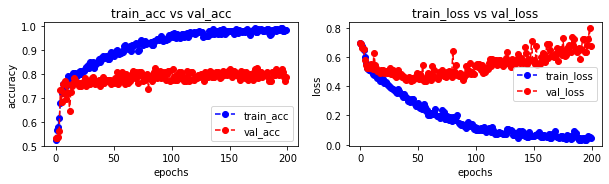

In [31]:
# visual to review the accuracy and loss per epoch on both validation and training
plot_accuracy_loss(history_8)

In [ ]:
from sklearn.metrics import recall_score

In [59]:
preds = model.predict(val_images_4) 

In [60]:
preds

array([[1.0231137e-03],
       [8.8394070e-01],
       [3.4683973e-02],
       [2.0018786e-01],
       [9.7514653e-01],
       [9.9921775e-01],
       [9.9698758e-01],
       [7.0430934e-03],
       [9.9534744e-01],
       [9.6578825e-01],
       [9.9999774e-01],
       [9.9999595e-01],
       [2.4712260e-06],
       [9.5606673e-01],
       [9.7415340e-01],
       [2.1620330e-01],
       [5.2457958e-01],
       [8.1796128e-01],
       [3.4891605e-02],
       [4.1852266e-02],
       [5.5048263e-01],
       [9.9984628e-01],
       [2.8589234e-01],
       [1.7353014e-07],
       [8.6793411e-01],
       [5.2483112e-02],
       [9.5453644e-01],
       [8.0363452e-03],
       [5.0699255e-06],
       [3.8967443e-01],
       [9.9998450e-01],
       [1.5205905e-01],
       [7.3252082e-02],
       [4.3046936e-01],
       [1.6766340e-02],
       [9.9996662e-01],
       [3.5790494e-01],
       [6.3594449e-01],
       [9.9372226e-01],
       [1.2004286e-02],
       [7.5999546e-01],
       [1.867941

In [61]:
pred_ped = []

for i in preds:
    if i > .5:
        pred_ped.append(1)
    else:
        pred_ped.append(0)
    
    

In [62]:
pred_ped

[0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0]

In [63]:
confusion_matrix(val_labels,pred_ped)

array([[72, 13],
       [34, 41]], dtype=int64)

In [64]:
tn, fp, fn, tp = confusion_matrix(val_labels,pred_ped).ravel()

In [65]:
(tn, fp, fn, tp)

(72, 13, 34, 41)

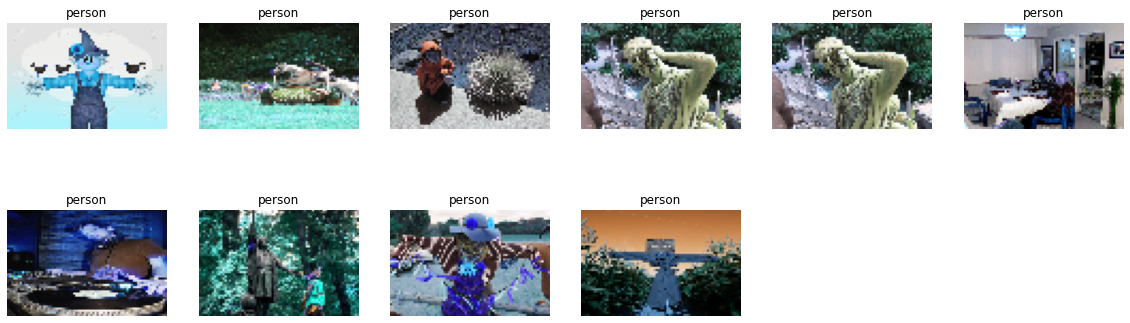

In [76]:
plt.figure(figsize=(20,20))
for n , i in enumerate(list(np.random.randint(0,len(val_images_4),10))) : 
    plt.subplot(6,6,n+1)
    plt.imshow(val_images[i])    
    plt.axis('off')
    x =np.argmax(pred_ped[0]) # takes the maximum of of the 6 probabilites. 
    plt.title((classes[x]))

In [ ]:
recall_score(y_test, y_pred)